### LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import pywt
from scipy.fftpack import fft,ifft,fftfreq
from scipy.signal import butter, lfilter, filtfilt, lfiltic , iirpeak, freqs, welch, iirfilter, hilbert
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks
from scipy.signal import argrelextrema
import scipy
from scipy import stats
from scipy.stats import gamma
import matplotlib.mlab as mlab
%matplotlib inline

### IMPORT DATA ON A DATAFRAME

In [2]:
filename1 = "1_Stave_supine_static.txt"
data_read = pd.read_table(filename1)

# Full data as dataframe
data = pd.DataFrame(data_read)

# Frequency
Freq = data['Log Freq'][1]              

# Reconstructing Real_Time
Time_stamp = data[['Timestamp']]        
data_time = pd.DataFrame(np.asarray(range(len(Time_stamp)))*(1/Freq), columns=['Time'])

# Acc & Gyro data on the three axis
data_ag = pd.concat([data_time,data[['AccX','AccY','AccZ']], data[['GyroX','GyroY','GyroZ']]],axis=1)

### FIRST PLOT VIEW

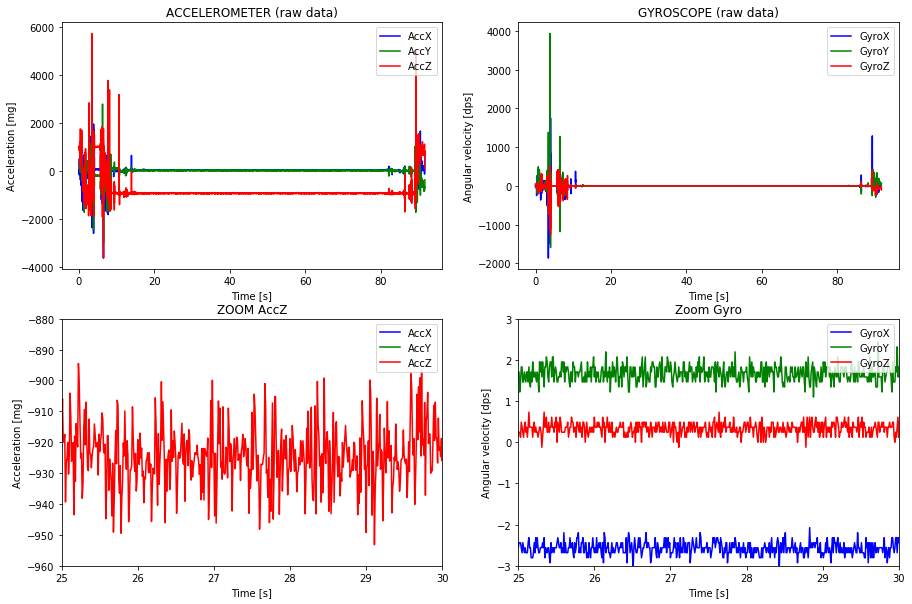

In [3]:
fig, axs = plt.subplots(2,2,figsize = (15,10))

axs[0,0].plot(data_ag['Time'],data_ag['AccX'],'b-',label='AccX')
axs[0,0].plot(data_ag['Time'],data_ag['AccY'],'g-',label='AccY')
axs[0,0].plot(data_ag['Time'],data_ag['AccZ'],'r-',label='AccZ')
axs[0,0].set_title( "ACCELEROMETER (raw data)")
axs[0,0].set_ylabel("Acceleration [mg]")
axs[0,0].set_xlabel('Time [s]')
axs[0,0].legend(loc=1)
#axs[0,0].set_xlim([15,20])
#axs[0,0].set_ylim([-1000,-900])
#################################
axs[0,1].plot(data_ag['Time'],data_ag['GyroX'],'b-',label='GyroX')
axs[0,1].plot(data_ag['Time'],data_ag['GyroY'],'g-',label='GyroY')
axs[0,1].plot(data_ag['Time'],data_ag['GyroZ'],'r-',label='GyroZ')
axs[0,1].set_title( "GYROSCOPE (raw data)")
axs[0,1].set_ylabel("Angular velocity [dps]")
axs[0,1].set_xlabel('Time [s]')
axs[0,1].legend(loc=1)
#######################################
axs[1,0].plot(data_ag['Time'],data_ag['AccX'],'b-',label='AccX')
axs[1,0].set_ylim([-1020,250])
#axs[1,0].set_ylim([-1000,-900])
axs[1,0].set_xlim([25,30])
axs[1,0].plot(data_ag['Time'],data_ag['AccY'],'g-',label='AccY')
axs[1,0].plot(data_ag['Time'],data_ag['AccZ'],'r-',label='AccZ')
axs[1,0].set_title( "ZOOM AccZ")
axs[1,0].set_ylabel("Acceleration [mg]")
axs[1,0].set_xlabel('Time [s]')
axs[1,0].set_ylim([-960,-880])
axs[1,0].legend(loc=1)
########################################
axs[1,1].plot(data_ag['Time'],data_ag['GyroX'],'b-',label='GyroX')
axs[1,1].plot(data_ag['Time'],data_ag['GyroY'],'g-',label='GyroY')
axs[1,1].plot(data_ag['Time'],data_ag['GyroZ'],'r-',label='GyroZ')
axs[1,1].set_title( "Zoom Gyro")
axs[1,1].set_ylabel("Angular velocity [dps]")
axs[1,1].set_xlabel('Time [s]')
axs[1,1].legend(loc=1)
axs[1,1].set_ylim([-3,3])
axs[1,1].set_xlim([25,30])

plt.savefig('01_raw_data.png', bbox_inches = "tight")

### Selecting window for data  

In [4]:
data_small_ag = data_ag[(data_ag['Time'] >= 20) & (data_ag['Time'] < 80)]
df_describe = data_small_ag.describe()
df_describe = df_describe.rename(columns={"Time": "Time [s]", "AccX": "AccX [mg]", "AccY": "AccY [mg]", "AccZ": "AccZ [mg]", "GyroX": "GyroX [rad/s]", "GyroY": "GyroY [rad/s]", "GyroZ": "GyroZ [rad/s]"})
df_describe.iloc[:,1:].round(1)

,AccX [mg],AccY [mg],AccZ [mg],GyroX [rad/s],GyroY [rad/s],GyroZ [rad/s]
count,6000.0,6000.0,6000.0,6000.0,6000.0,6000.0
mean,44.2,21.5,-924.2,-2.5,1.7,0.3
std,4.6,3.0,9.7,0.1,0.2,0.2
min,26.5,8.3,-954.6,-3.2,1.1,-0.2
25%,41.4,19.6,-929.2,-2.7,1.6,0.2
50%,44.2,21.5,-924.2,-2.6,1.7,0.4
75%,46.9,23.5,-919.1,-2.4,1.8,0.5
max,63.6,33.7,-891.6,-2.1,2.4,1.0


## Fourier Function

In [5]:
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2]) 
    return f_values, fft_values

def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

def FFT_analysis(y_values, T, length_data):                        # Directly Fourier for Filter
    x_FFT = np.fft.fftfreq(length_data, T)
    y_FFT = np.fft.fft(y_values)
    df_FFT = pd.DataFrame({'Freq':x_FFT, 'Amplitude':y_FFT})
    return df_FFT

def FFT_filter(df_FFT, Freq_min, Freq_max):                       #Filtering using a Fourier interval
    df_FFT[df_FFT['Freq'].abs() < Freq_min] = 0
    df_FFT[df_FFT['Freq'].abs() > Freq_max] = 0
    Antitransform = np.fft.ifft(df_FFT['Amplitude'])
    return Antitransform

## FILTER

In [6]:
def my_filter(filter_order, frequency_in, filter_type ,sampling_freq_system, data_in):
    b,a = butter(filter_order,frequency_in, filter_type, fs = sampling_freq_system)
    frequency_responsew,h = freqs(b,a)
    data_filtered = filtfilt(b,a, data_in)  
    return data_filtered 

def my_narrow(frequency_in , fs , quality_factor, data_in):
    w0 = frequency_in/(fs/2)
    b, a = iirpeak(w0, quality_factor)
    data_filtered = filtfilt(b,a, data_in)  
    return data_filtered

def iir_filter(filter_order, frequency_in, filter_type , design, data_in, sampling_freq_system):
    b,a = iirfilter(filter_order,frequency_in, btype=filter_type, ftype=design, fs=sampling_freq_system)
    data_filtered = filtfilt(b,a, data_in)
    return data_filtered


## Finding maxima

In [7]:
def maxima_minima(time, filtereddata):
    df_filter = pd.DataFrame({'Time':time, 'Filtered':filtereddata})
    df_filter['min'] = df_filter.iloc[argrelextrema(df_filter.Filtered.values, np.less_equal, order=10)[0]]['Filtered']
    df_filter['max'] = df_filter.iloc[argrelextrema(df_filter.Filtered.values, np.greater_equal, order=10)[0]]['Filtered']
    return df_filter

def find_min(df_filter):
    time_max_array = df_filter[['Time', 'min']]
    value_best = time_max_array[(time_max_array['min'] < 0)]  
    difference = value_best.diff()
    return difference.dropna()
    
def find_max(df_filter):
    time_max_array = df_filter[['Time', 'max']]
    value_best = time_max_array[(time_max_array['max'] < 0)]  
    difference = value_best.diff()
    return difference.dropna()

# FFT analysis & filter

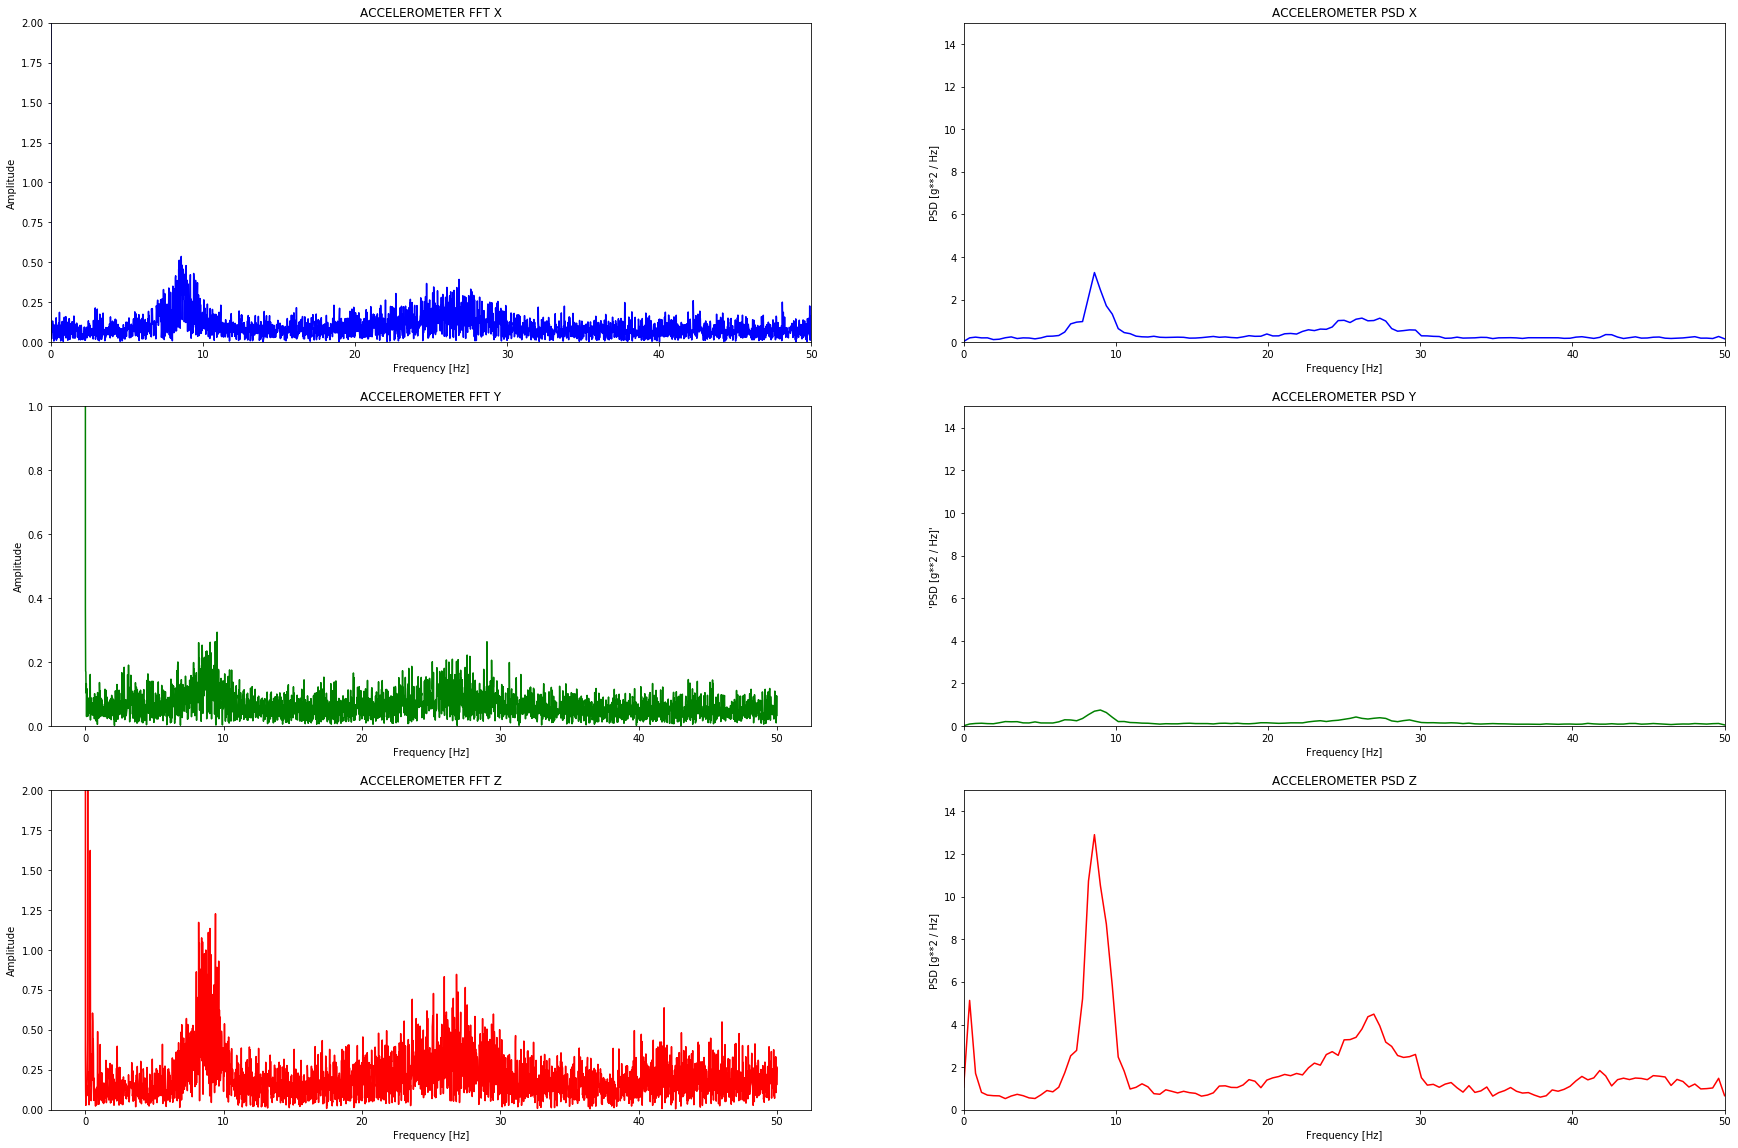

In [8]:
N = data_small_ag.shape[0]
T = 1/Freq   
f_s = Freq   

f_values, fft_values = get_fft_values(data_small_ag['AccX'], T, N, f_s)
f_values_psd, psd_values = get_psd_values(data_small_ag['AccX'], T, N, f_s)

f_values_g, fft_values_g = get_fft_values(data_small_ag['AccY'], T, N, f_s)
f_values_psd_g, psd_values_g = get_psd_values(data_small_ag['AccY'], T, N, f_s)

f_values_z, fft_values_z = get_fft_values(data_small_ag['AccZ'], T, N, f_s)
f_values_psd_z, psd_values_z = get_psd_values(data_small_ag['AccZ'], T, N, f_s)

#PLOTTING
fig, axs = plt.subplots(3,2,figsize = (30,20))
axs[0,0].plot(f_values,fft_values,'b')
axs[0,0].set_title( "ACCELEROMETER FFT X")
#axs[0,0].axis([0,50,0,0.3])
axs[0,0].axis([0,50,0,2])
axs[0,0].set_ylabel("Amplitude")
axs[0,0].set_xlabel('Frequency [Hz]')
axs[0,1].plot(f_values_psd, psd_values, linestyle='-', color='blue')
axs[0,1].set_title("ACCELEROMETER PSD X")
axs[0,1].axis([0,50,0,15])
axs[0,1].set_ylabel("PSD [g**2 / Hz]")
axs[0,1].set_xlabel('Frequency [Hz]')
##############################################
axs[1,0].plot(f_values_g,fft_values_g,'g')
axs[1,0].set_title( "ACCELEROMETER FFT Y")
#axs[1,0].axis([0,50,0,0.3])
axs[1,0].set_ylim([0,1])
axs[1,0].set_ylabel("Amplitude")
axs[1,0].set_xlabel('Frequency [Hz]')
axs[1,1].plot(f_values_psd_g, psd_values_g, linestyle='-', color='g')
axs[1,1].axis([0,50,0,15])
axs[1,1].set_title("ACCELEROMETER PSD Y")
axs[1,1].set_ylabel("'PSD [g**2 / Hz]'")
axs[1,1].set_xlabel('Frequency [Hz]')
##############################################
axs[2,0].plot(f_values_z,fft_values_z,'r')
axs[2,0].set_title( "ACCELEROMETER FFT Z")
#axs[2,0].axis([0,50,0,0.3])
axs[2,0].set_ylim([0,2])
axs[2,0].set_ylabel("Amplitude")
axs[2,0].set_xlabel('Frequency [Hz]')
axs[2,1].plot(f_values_psd_z, psd_values_z, linestyle='-', color='r')
axs[2,1].set_title("ACCELEROMETER PSD Z")
axs[2,1].axis([0,50,0,15])
axs[2,1].set_ylabel("PSD [g**2 / Hz]")
axs[2,1].set_xlabel('Frequency [Hz]')

plt.savefig('03_acc_freq_undermat.png', bbox_inches = "tight")

In [9]:
mean_ampl_acc1 = data_small_ag[['AccZ']].mean()
mean_ampl_acc = mean_ampl_acc1[0]

In [10]:
############################################################################################
result_2 = my_filter(3, [25,31] , 'band', 100, data_small_ag['AccZ'])
############################################################################################
#result_3 = my_narrow(28, 100, 1, data_small_ag['AccZ'])
#result_2 = my_filter(3, [6,11] , 'band', 100, data_small_ag['AccZ'])
#result_2 = iir_filter(4, [6,12] , 'bandpass', 'butter', data_small_ag['AccZ'], 200)


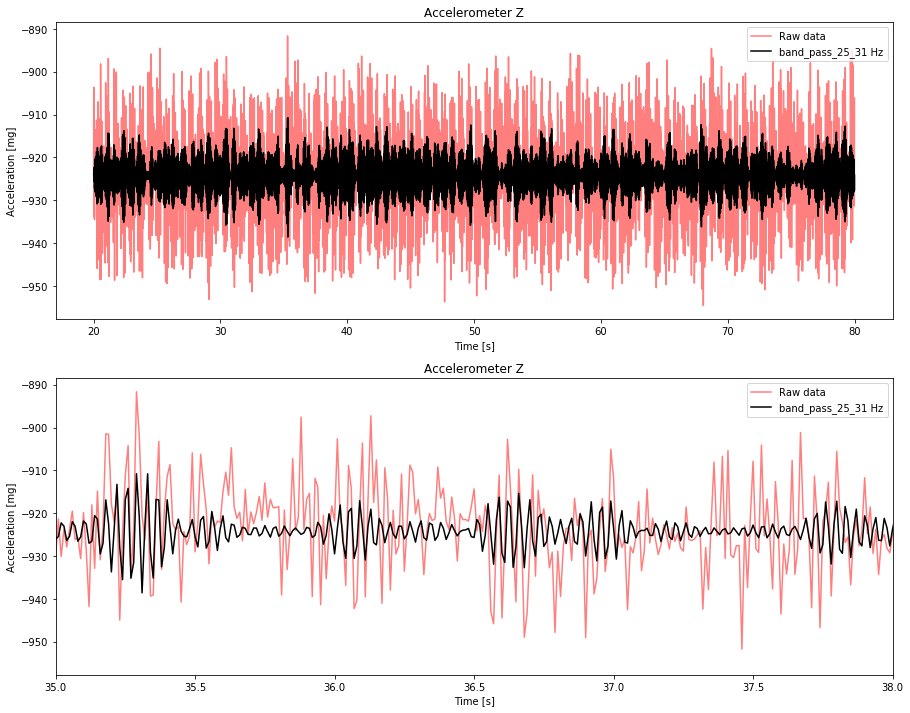

In [11]:
fig, axs = plt.subplots(2,1,figsize = (15,12))


######################################################################
axs[0].plot(data_small_ag['Time'],data_small_ag['AccZ'],'r', alpha = 0.5, label = 'Raw data')
axs[0].plot(data_small_ag['Time'], result_2+mean_ampl_acc,'k',label='band_pass_25_31 Hz')
axs[0].set_xlabel('Time [s]')
axs[0].set_title('Accelerometer Z')
axs[0].set_ylabel('Acceleration [mg]')
axs[0].legend(loc = 'upper right')
######################################################################
axs[1].plot(data_small_ag['Time'],data_small_ag['AccZ'],'r', alpha = 0.5, label = 'Raw data')
axs[1].plot(data_small_ag['Time'], result_2+mean_ampl_acc,'k',label='band_pass_25_31 Hz')
axs[1].set_xlabel('Time [s]')
axs[1].set_title('Accelerometer Z')
axs[1].set_ylabel('Acceleration [mg]')
axs[1].set_xlim([35,38])
axs[1].legend(loc = 'upper right')

plt.savefig('04_acc_bandpass.png', bbox_inches = "tight")

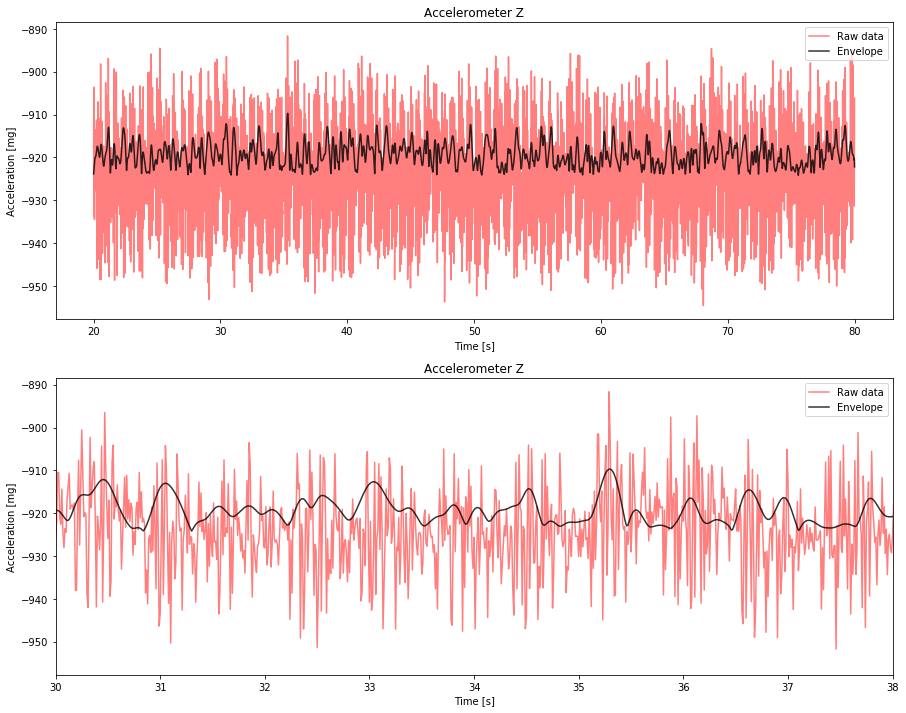

In [12]:
hilb_prv = hilbert(result_2)
amplitude_envelope = np.abs(hilb_prv)

fig, axs = plt.subplots(2,1,figsize = (15,12))
######################################################################
axs[0].plot(data_small_ag['Time'],data_small_ag['AccZ'],'r', alpha = 0.5, label = 'Raw data')
axs[0].plot(data_small_ag['Time'], amplitude_envelope+mean_ampl_acc,'k', alpha = 0.8,label='Envelope')
axs[0].set_xlabel('Time [s]')
axs[0].set_title('Accelerometer Z')
axs[0].set_ylabel('Acceleration [mg]')
axs[0].legend(loc = 'upper right')
######################################################################
axs[1].plot(data_small_ag['Time'],data_small_ag['AccZ'],'r', alpha = 0.5, label = 'Raw data')
axs[1].plot(data_small_ag['Time'], amplitude_envelope+mean_ampl_acc,'k',alpha = 0.8,label='Envelope')
axs[1].set_xlabel('Time [s]')
axs[1].set_title('Accelerometer Z')
axs[1].set_ylabel('Acceleration [mg]')
axs[1].set_xlim([30,38])
axs[1].legend(loc = 'upper right')

plt.savefig('05_acc_hilbert.png', bbox_inches = "tight")

# FIRST ALGORITHM

In [13]:
new_dataframe_envel = pd.DataFrame({'Time':data_small_ag['Time'], 'Filtered':amplitude_envelope+mean_ampl_acc})

result_ev_fil = my_filter(5, 2 , 'low', 100, amplitude_envelope+mean_ampl_acc)

#guarda i massimi
max_z_acc = maxima_minima(data_small_ag['Time'].values, result_ev_fil)

#look at time distance between max
tempi_max_z_acc = find_max(max_z_acc)

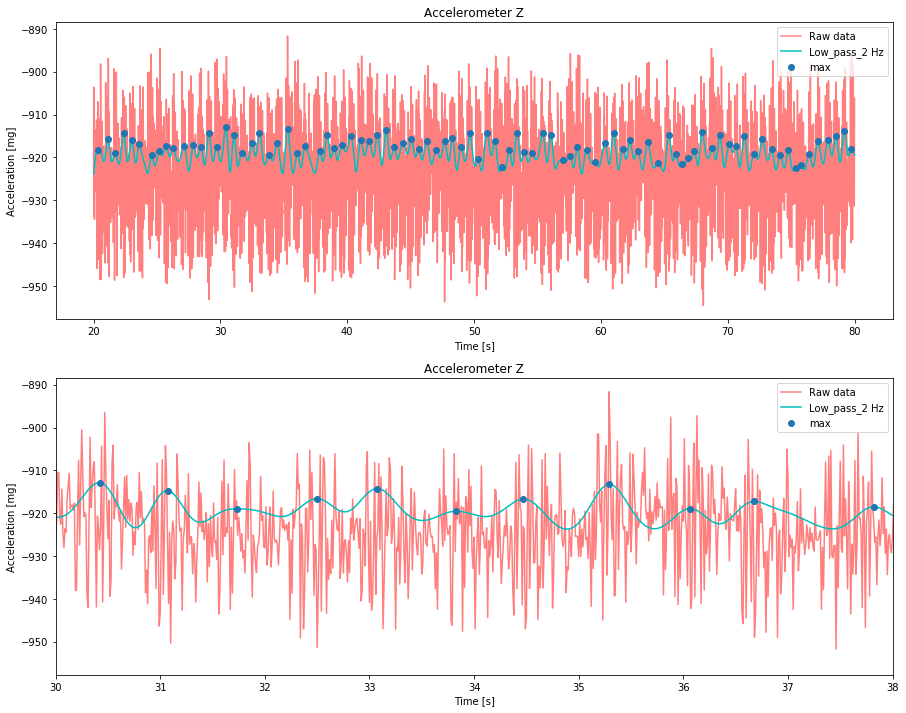

In [14]:
fig, axs = plt.subplots(2,1,figsize = (15,12))
######################################################################
axs[0].plot(data_small_ag['Time'],data_small_ag['AccZ'],'r', alpha = 0.5, label = 'Raw data')
axs[0].plot(data_small_ag['Time'], result_ev_fil,'c',label='Low_pass_2 Hz')
axs[0].set_xlabel('Time [s]')
axs[0].set_title('Accelerometer Z')
axs[0].set_ylabel('Acceleration [mg]')
axs[0].plot(max_z_acc['Time'], max_z_acc['max'], 'o')
axs[0].legend(loc = 'upper right')
######################################################################
axs[1].plot(data_small_ag['Time'],data_small_ag['AccZ'],'r', alpha = 0.5, label = 'Raw data')
axs[1].plot(data_small_ag['Time'], result_ev_fil,'c',label='Low_pass_2 Hz')
axs[1].plot(max_z_acc['Time'], max_z_acc['max'], 'o')
axs[1].set_xlabel('Time [s]')
axs[1].set_title('Accelerometer Z')
axs[1].set_ylabel('Acceleration [mg]')
axs[1].set_xlim([30,38])
axs[1].legend(loc = 'upper right')

plt.savefig('06_acc_hilbert.png', bbox_inches = "tight")

0.6670786516853933 0.11381240475815334


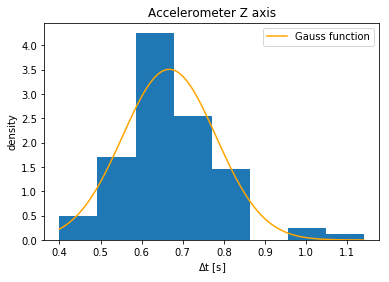

In [15]:
#histogram
from scipy.stats import norm

fit_alpha_max, fit_loc_max, fit_beta_max = stats.gamma.fit(tempi_max_z_acc['Time'].values)
(mi_x, sigma_x) = stats.norm.fit(tempi_max_z_acc['Time'].values)
gamma_max = gamma(fit_alpha_max, loc = fit_loc_max, scale = fit_beta_max)
gauss = norm(loc = mi_x, scale= sigma_x) 

x = np.arange( min(min(tempi_max_z_acc['Time'].values), min(tempi_max_z_acc['Time'].values)), max(max(tempi_max_z_acc['Time'].values), max(tempi_max_z_acc['Time'].values)) + 0.01, 0.01)

plt.hist(tempi_max_z_acc['Time'].values, bins = 8, density = True)
plt.plot(x, gauss.pdf(x), color = 'orange', label = "Gauss function")
plt.title("Accelerometer Z axis")
plt.xlabel("$\Delta$t [s]")
plt.ylabel("density")
plt.legend()

plt.savefig('07_acc_distrib.png', bbox_inches = "tight")
#plt.ylim([0,7])
print(mi_x, sigma_x)

In [16]:
mi = np.mean(tempi_max_z_acc['Time'].values)
sigma_x = np.std(tempi_max_z_acc['Time'].values)
print(mi, ' ', sigma_x)

0.6670786516853933   0.11381240475815334


In [17]:
print('The std of BPM',(60/(mi)**2)*sigma_x)
print('BPM:', 60/mi)

The std of BPM 15.345702183680414
BPM: 89.944416371905


In [18]:
from scipy.stats import skew, kurtosis

skew(tempi_max_z_acc['Time'], axis = 0)

1.0152751931161705

In [19]:
kurtosis(tempi_max_z_acc['Time'], axis = 0)#, fisher = 0)

2.5700406285796777

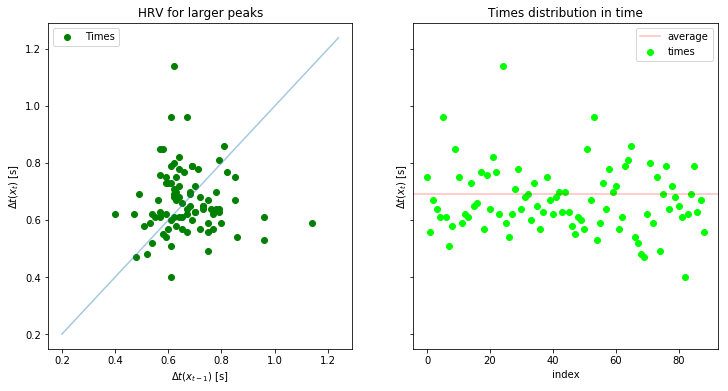

In [20]:
x = np.linspace(0.2, max(tempi_max_z_acc['Time'])+ 0.1 , 100)

fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey = True)

#da vedere se mettere
ax[0].scatter(tempi_max_z_acc['Time'].values[:-1], tempi_max_z_acc['Time'].values[1:], color = 'g', label = "Times")
ax[0].set_title("HRV for larger peaks")
ax[0].set_xlabel("$\Delta t (x_{t-1})$ [s]")
ax[0].set_ylabel("$\Delta t (x_{t})$ [s]")
ax[0].plot(x,x, alpha=0.4)
ax[0].legend()


ax[1].scatter(np.arange(len(tempi_max_z_acc['Time'].values)), tempi_max_z_acc['Time'].values, color = 'lime', label = "times")
ax[1].axhline(0.69, color = 'red', alpha = 0.25, label = 'average')
ax[1].set_title("Times distribution in time")
ax[1].set_xlabel("index")
ax[1].set_ylabel("$\Delta t (x_{t})$ [s]")
ax[1].legend()

plt.savefig('08_HRV_distrib.png', bbox_inches = "tight")


# SECOND ALGORITHM (changing also filter parameter!!!!)

In [21]:
result_2 = my_filter(3, [1,20] , 'band', 100, data_small_ag['AccZ'])

hilb_prv = hilbert(result_2)
amplitude_envelope = np.abs(hilb_prv)

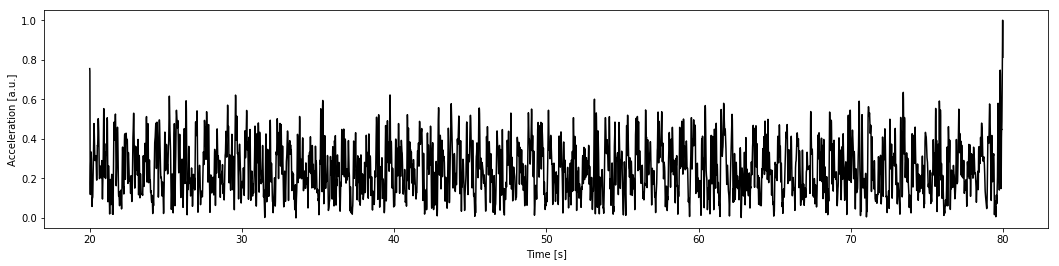

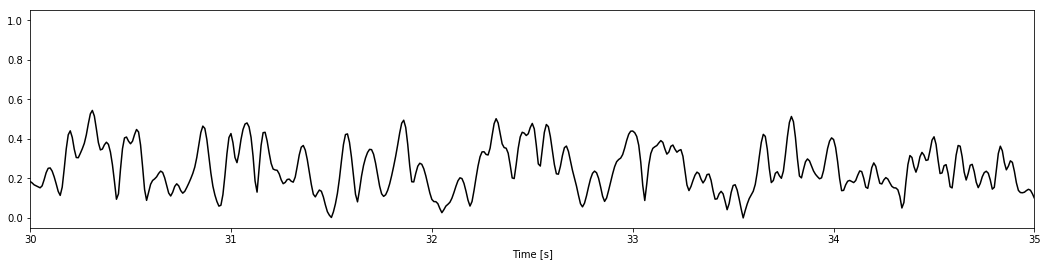

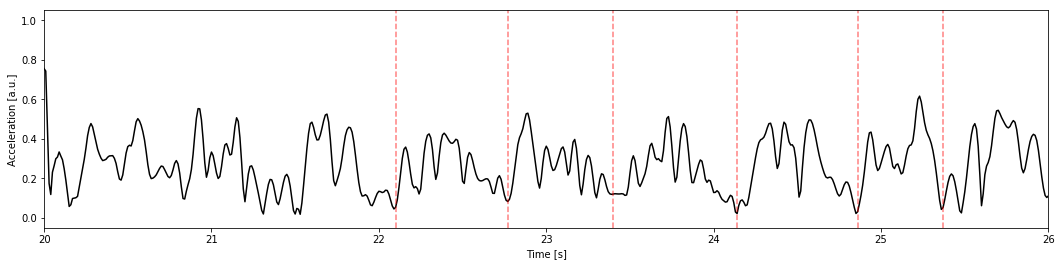

In [22]:
Filtered = pd.DataFrame({'Time':data_small_ag['Time'].values, 'values':amplitude_envelope})
#Filtered.columns = ["Time","values"]
#Filtered

maximum = np.max(Filtered["values"])
minimum = np.min(Filtered["values"])

Filtered["values"]= (Filtered["values"] - minimum)/(maximum - minimum)
Filtered.describe()

plt.figure
fig = plt.figure(figsize=(18,4))
plt.plot(Filtered['Time'],Filtered['values'],'k')
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [a.u.]")
plt.show()

fig = plt.figure(figsize=(18,4))
plt.plot(Filtered['Time'],Filtered['values'],'k')
plt.xlim([30,35])
plt.xlabel("Time [s]")
plt.show("Acceleration [a.u.]")

fig = plt.figure(figsize=(18,4))
plt.plot(Filtered['Time'],Filtered['values'],'k')
plt.xlim([20,26])
plt.axvline(22.10, alpha = 0.5, color = 'red', ls = 'dashed')
plt.axvline(22.77,  alpha = 0.5, color = 'red',  ls = 'dashed')
plt.axvline(23.4,  alpha = 0.5, color = 'red',  ls = 'dashed')
plt.axvline(24.14,  alpha = 0.5, color = 'red',  ls = 'dashed')
plt.axvline(24.86,  alpha = 0.5, color = 'red',  ls = 'dashed')
plt.axvline(25.37,  alpha = 0.5, color = 'red',  ls = 'dashed')
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [a.u.]")
plt.show()

In [23]:
def lambda_f(diff_time, mu):
    lambda_const = 1/mu
    mean_value = mu
    
    if diff_time <= 0:
        return 0
    return lambda_const*np.exp(-lambda_const*np.abs(mean_value - diff_time))

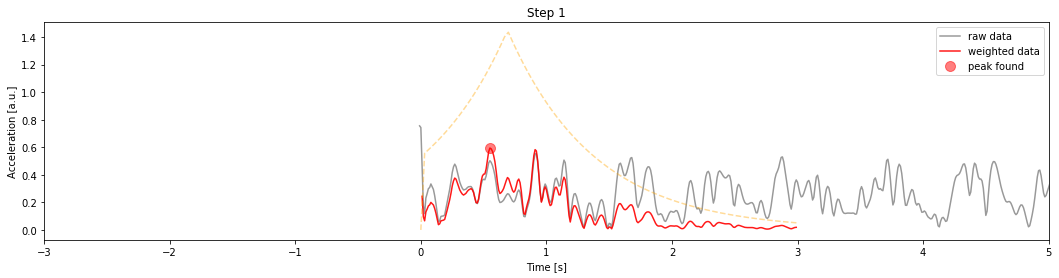

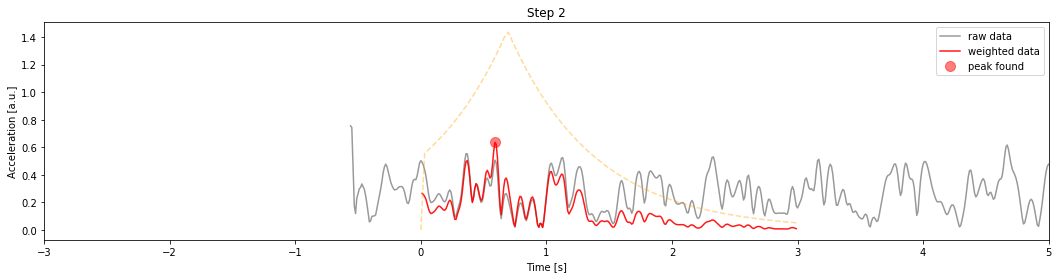

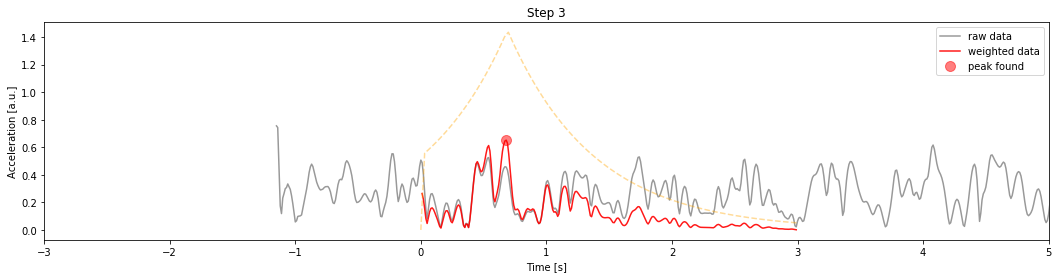

In [24]:
temporary = pd.DataFrame(Filtered)

max_df = pd.DataFrame()

peso = 1.
mean = 0.69

x = np.linspace(0, 3, 100)
y = []
for i in x:
    y.append(lambda_f(i,mean))
y = np.array(y)

temporary["Time"] = temporary["Time"] - temporary["Time"].min()          #start from zero

frag = temporary[(Filtered["Time"] > 0) & (temporary["Time"] < 0.8)]     #see in first interval and  
offset1 = temporary[temporary["values"] == frag["values"].max()]["Time"]  #get the time of the maximum in first window

temporary["Time"] = temporary["Time"] - offset1.values

time_window = temporary[(temporary["Time"] > (0) ) & (temporary["Time"] < (3.) )] #start a timewindow from the first peak
df_window = pd.DataFrame({"Time": time_window["Time"], "values": time_window["values"]})

weighted =  df_window["Time"].apply(lambda_f, mu = mean )*df_window["values"]*peso + df_window["values"]*(1-peso)
df_weighted = pd.DataFrame({"Time": df_window["Time"], "values_weighted": weighted})

offset2 = df_weighted[df_weighted["values_weighted"] == df_weighted["values_weighted"].max()]["Time"] #find new weighted max
max_df = df_weighted[df_weighted["values_weighted"] == df_weighted["values_weighted"].max()]

fig = plt.figure(figsize=(18,4))
plt.plot(temporary['Time'],temporary['values'],'k', alpha = 0.4, label = "raw data")
plt.plot(df_weighted['Time'],df_weighted['values_weighted'],'r', alpha = 0.9, label = "weighted data")
plt.plot(max_df['Time'], max_df['values_weighted'],'ro', alpha = 0.5, markersize = 10, label = 'peak found')
plt.plot(x, y, ls = 'dashed', color = 'orange', alpha = 0.4)
plt.xlim([-3,5])
plt.xlabel("Time [s]")
plt.title("Step 1")
plt.ylabel("Acceleration [a.u.]")
plt.legend()
plt.show()

offset2 = df_weighted[df_weighted["values_weighted"] == df_weighted["values_weighted"].max()]["Time"] #find new weighted max
temporary["Time"] = temporary["Time"] - offset2.values

time_window = temporary[(temporary["Time"] > (0) ) & (temporary["Time"] < (3.) )] #start a timewindow from the first peak
df_window = pd.DataFrame({"Time": time_window["Time"], "values": time_window["values"]})

weighted =  df_window["Time"].apply(lambda_f, mu = mean )*df_window["values"]*peso + df_window["values"]*(1-peso)
df_weighted = pd.DataFrame({"Time": df_window["Time"], "values_weighted": weighted})

offset3 = df_weighted[df_weighted["values_weighted"] == df_weighted["values_weighted"].max()]["Time"] #find new weighted max
max_df = df_weighted[df_weighted["values_weighted"] == df_weighted["values_weighted"].max()]

fig = plt.figure(figsize=(18,4))
plt.plot(temporary['Time'],temporary['values'],'k', alpha = 0.4, label = "raw data")
plt.plot(df_weighted['Time'],df_weighted['values_weighted'],'r', alpha = 0.9, label = "weighted data")
plt.plot(max_df['Time'], max_df['values_weighted'],'ro', alpha = 0.5, markersize = 10, label = 'peak found')
plt.xlim([-3,5])
plt.plot(x, y, ls = 'dashed', color = 'orange', alpha = 0.4)
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [a.u.]")
plt.title("Step 2")
plt.legend()
plt.show()

offset3 = df_weighted[df_weighted["values_weighted"] == df_weighted["values_weighted"].max()]["Time"] #find new weighted max
temporary["Time"] = temporary["Time"] - offset3.values

time_window = temporary[(temporary["Time"] > (0) ) & (temporary["Time"] < (3.) )] #start a timewindow from the first peak
df_window = pd.DataFrame({"Time": time_window["Time"], "values": time_window["values"]})

weighted =  df_window["Time"].apply(lambda_f, mu = mean )*df_window["values"]*peso + df_window["values"]*(1-peso)
df_weighted = pd.DataFrame({"Time": df_window["Time"], "values_weighted": weighted})
max_df = df_weighted[df_weighted["values_weighted"] == df_weighted["values_weighted"].max()]

fig = plt.figure(figsize=(18,4))
plt.plot(temporary['Time'],temporary['values'],'k', alpha = 0.4, label = "raw data")
plt.plot(df_weighted['Time'],df_weighted['values_weighted'],'r', alpha = 0.9, label = "weighted data")
plt.xlim([-3,5])
plt.plot(max_df['Time'], max_df['values_weighted'],'ro', alpha = 0.5, markersize = 10, label = 'peak found')
plt.plot(x, y, ls = 'dashed', color = 'orange', alpha = 0.4)
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [a.u.]")
plt.title("Step 3")
plt.legend()
plt.show()

In [25]:
def convolution(dataset, peso):
    mus = []
    medie = []
    varianze = []
    battiti = []
    pesi = []  #quanto vale la convoluzione esponenziale*dataset rispetto all'altra
    
    for mean in np.arange(0.60, 1.0, 0.01):

        dataset["Time"] = dataset["Time"] - dataset["Time"].min()                #start from zero        
        
        frag = dataset[(dataset["Time"] > 0) & (dataset["Time"] < 0.8)]          #see in first interval and
        offset = dataset[dataset["values"] == frag["values"].max()]["Time"]      #get the time of the maximum
        
        dataset["Time"] = dataset["Time"] - offset.values                        #use first maxima as starting point

        times_list = []
        
        for i in range(400):
            
            #translate old dataset
            if (i == 0):
                temporary = pd.DataFrame({"Time": dataset["Time"], "values": dataset["values"] })
            else:
                temporary = pd.DataFrame({"Time": dataset["Time"] - np.sum(np.array(times_list)), "values": dataset["values"] })

            #make a slicing and use a shorter time window (i.e. assumption that heartbeat is within 3 sec)
            time_window = temporary[(temporary["Time"] > (0) ) & (temporary["Time"] < (3.) )] 
            df_window = pd.DataFrame({"Time": time_window["Time"].values, "values": time_window["values"]})

            #"center" the exponential in zero (i.e. offset) and make the convolution with the probability
            weighted = df_window["Time"].apply(lambda_f, mu = mean )*df_window["values"]*peso + df_window["values"]*(1-peso)
            df_weighted = pd.DataFrame({"Time": df_window["Time"], "values_weighted": weighted})

            #find the maximum and its time
            offset = df_weighted[df_weighted["values_weighted"] == df_weighted["values_weighted"].max()]["Time"] #times for first max
    
            if ( (temporary["Time"].max()) < 1): 
                break
            else: 
                times_list.append(offset.values[0])
    
        (mu, sigma) = stats.norm.fit(times_list)
        gauss = norm(loc = mu, scale = sigma)
#    print("With mean: ", mean, "We found", len(times_list), "heartbeats.")
#    print("Time between heartbeats is: ", mu , ".   Variance is: ",  sigma, "\n" )
    
        mus.append(mean)                    #mean used for the exponential
        medie.append(mu)                    #mu found by gaussian interpolation
        varianze.append(sigma)              #sigma found by gaussian interpolation
        battiti.append(len(times_list))     #number of heartbeats
        pesi.append(peso*100)               #weights for the convolution
        
    return  pd.DataFrame({"Mu used [s]": mus, "Mean found [s]": medie , 
                        "Variance found [s]": varianze, "Number of heartbeats": battiti, 
                        "Convolution weight [%]": pesi})

In [26]:
summary = pd.DataFrame()

for peso in np.arange(0.3, 1.1, 0.1):
    summary = summary.append(convolution(Filtered, peso))

#best results are the ones with lowest variance
summary.sort_values("Variance found [s]")

,Mu used [s],Mean found [s],Variance found [s],Number of heartbeats,Convolution weight [%]
3,0.63,0.687326,0.088297,86,100.0
4,0.64,0.687326,0.091644,86,100.0
5,0.65,0.687326,0.094468,86,100.0
2,0.62,0.679425,0.098615,87,100.0
5,0.65,0.687442,0.099103,86,90.0
6,0.66,0.687442,0.101273,86,100.0
4,0.64,0.687442,0.102608,86,90.0
7,0.67,0.687442,0.102823,86,100.0
9,0.69,0.687442,0.103465,86,100.0
8,0.68,0.687442,0.104938,86,100.0


In [27]:
summary.sort_values("Variance found [s]").head(10)

,Mu used [s],Mean found [s],Variance found [s],Number of heartbeats,Convolution weight [%]
3,0.63,0.687326,0.088297,86,100.0
4,0.64,0.687326,0.091644,86,100.0
5,0.65,0.687326,0.094468,86,100.0
2,0.62,0.679425,0.098615,87,100.0
5,0.65,0.687442,0.099103,86,90.0
6,0.66,0.687442,0.101273,86,100.0
4,0.64,0.687442,0.102608,86,90.0
7,0.67,0.687442,0.102823,86,100.0
9,0.69,0.687442,0.103465,86,100.0
8,0.68,0.687442,0.104938,86,100.0


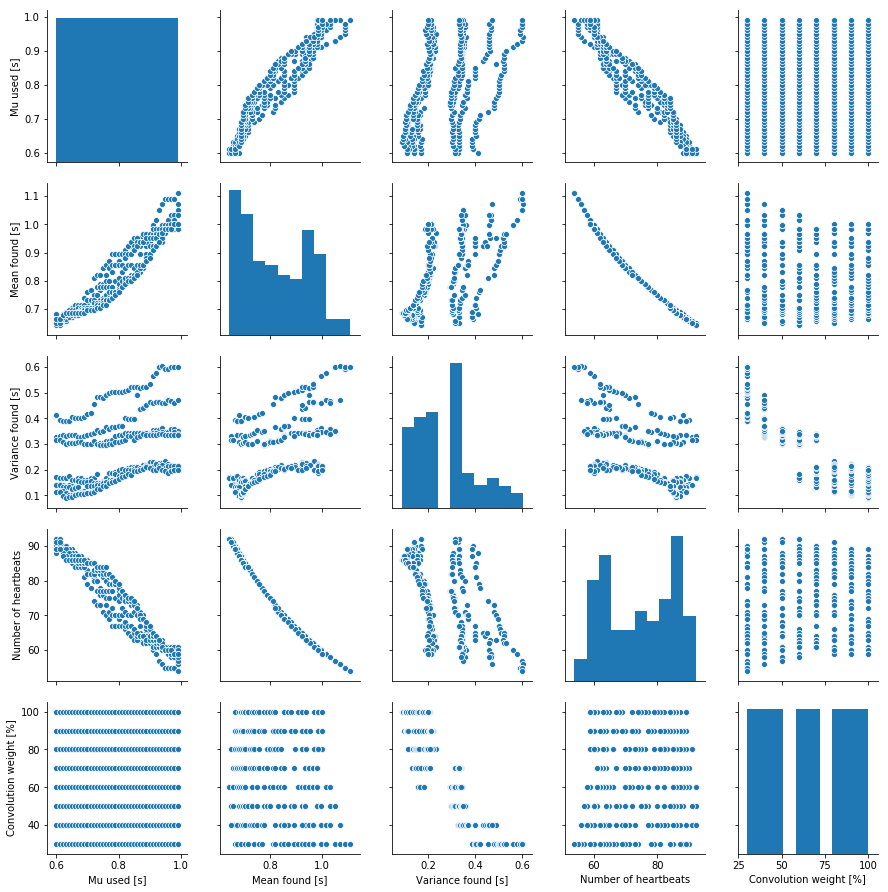

In [28]:
sns.pairplot(summary)

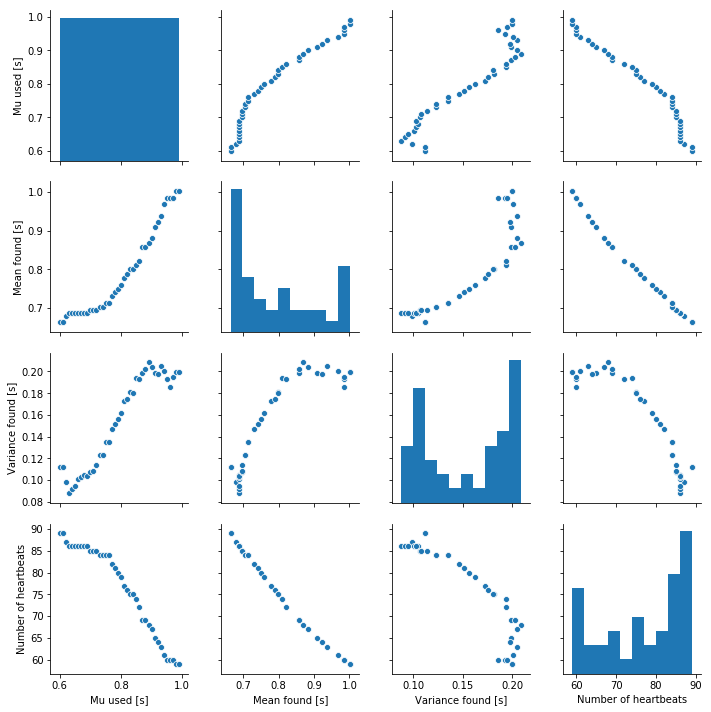

In [29]:
average_best = convolution(Filtered, 1.)
sns.pairplot(average_best[["Mu used [s]","Mean found [s]","Variance found [s]","Number of heartbeats"]])

# SEE TIMES DISTRIBUTION FOR THE BEST ESTIMATE

In [30]:
Filtered["Time"] = Filtered["Time"] - Filtered["Time"].min()                #start from zero        
        
frag = Filtered[(Filtered["Time"] > 0) & (Filtered["Time"] < 0.8)]          #see in first interval and
offset = Filtered[Filtered["values"] == frag["values"].max()]["Time"]      #get the time of the maximum
        
Filtered["Time"] = Filtered["Time"] - offset.values                        #use first maximum as starting point

times_list = []
peso = 1
mean = 0.63

for i in range(400):
            
#translate old Filtered
    if (i == 0):
        temporary = pd.DataFrame({"Time": Filtered["Time"], "values": Filtered["values"] })
    else:
        temporary = pd.DataFrame({"Time": Filtered["Time"] - np.sum(np.array(times_list)), "values": Filtered["values"] })

            #make a slicing and use a shorter time window (i.e. assumption that heartbeat is within 3 sec)
    time_window = temporary[(temporary["Time"] > (0) ) & (temporary["Time"] < (3.) )] 
    df_window = pd.DataFrame({"Time": time_window["Time"].values, "values": time_window["values"]})

            #"center" the exponential in zero (i.e. offset) and make the convolution with the probability
    weighted = df_window["Time"].apply(lambda_f, mu = mean )*df_window["values"]*peso + df_window["values"]*(1-peso)
    df_weighted = pd.DataFrame({"Time": df_window["Time"], "values_weighted": weighted})

            #find the maximum and its time
    offset = df_weighted[df_weighted["values_weighted"] == df_weighted["values_weighted"].max()]["Time"] #times for first max
    
    if ( (temporary["Time"].max()) < 1): 
        break
    else: 
        times_list.append(offset.values[0])
    
    (mu, sigma) = stats.norm.fit(times_list)
    gauss = norm(loc = mu, scale = sigma)

In [31]:
#####################################################################################
#Returns chi square, given observed values, function to be tested and its number of parameters
#####################################################################################
def chisq(observed, predic, params):
    chisquare = 0
    dof = len(observed)-params
    for i in observed:
        chisquare += ((i-predic(i))**2)/predic(i)
    
    return (chisquare/dof)

Parameters of gaussian functions all times are:  0.6873255813953488 0.08829686210290923

ChiSquare gauss =  2.247806272447347 0.8661960297698572 





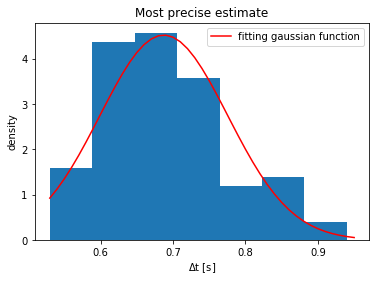

In [32]:
from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import chi2


#fit with gauss and then instantiate it
(mu, sigma) = stats.norm.fit(times_list)
gauss = norm(loc = mu, scale = sigma)

#compute chi square and print results
chisq_gauss  = chisq( times_list , gauss.pdf, 2) #NORMAL CHISQUARE

print("Parameters of gaussian functions all times are: ", mu, sigma)
print("\nChiSquare gauss = ", chisq_gauss, chi2.cdf(chisq_gauss, df = 1), "\n\n\n" )

x = np.arange(min(times_list), max(times_list) + 0.01, 0.01)

#plot everything
plt.plot(x, gauss.pdf(x), color = 'red', label = "fitting gaussian function")
plt.hist(times_list, bins = 7, density = True)
plt.xlabel("$\Delta$t [s]")
plt.ylabel("density")
plt.legend()
plt.title("Most precise estimate")
plt.show()

In [33]:
print('The std of BPM',(60/(mu)**2)*sigma)
print('BPM:', 60/mu)

The std of BPM 11.214282804699815
BPM: 87.29487396379632


# HRV

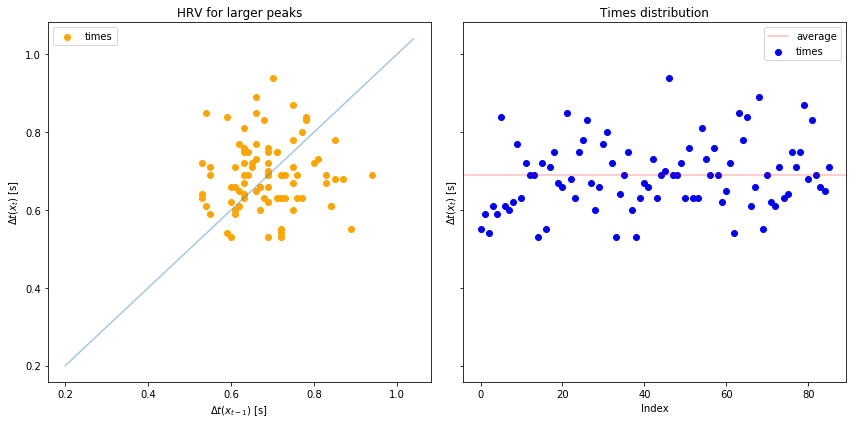

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey = True)

x = np.linspace(0.2, max(times_list)+0.1,100)
ax[0].scatter(times_list[:-1], times_list[1:], color = 'orange', label = "times")
ax[0].set_title("HRV for larger peaks")
ax[0].set_xlabel("$\Delta t (x_{t-1})$ [s]")
ax[0].set_ylabel("$\Delta t (x_{t})$ [s]")
ax[0].plot(x,x, alpha = 0.4)
ax[0].legend()

ax[1].scatter(np.arange(len(times_list)), times_list, color = 'blue', label = "times")
ax[1].set_title("Times distribution")
ax[1].set_xlabel("Index")
ax[1].set_ylabel("$\Delta t (x_{t})$ [s]")
ax[1].axhline(0.69, color = 'red', alpha = 0.25, label = 'average')
ax[1].legend()
plt.tight_layout()
plt.show()

In [35]:
c = np.array([1,4,7])

In [36]:
np.mean(c)

4.0

In [37]:
np.std(c)

2.449489742783178